In [144]:
# Importamos las librerías que necesitamos

# Librerías de extracción de datos
# -----------------------------------------------------------------------

%load_ext autoreload
%autoreload 2

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

import sys
sys.path.append('../')
from src import funciones as f
from src import soporte_prep as sp

import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parque Vehicular España

In [145]:
df_parque_vehicular_es = pd.read_excel("C:\\Users\\DELL\\Downloads\\Parque-de-vehiculos-Series-historicas-2023.xlsx", sheet_name='parque_ciclomotores', skiprows=2)

In [146]:
df_parque_vehicular_es.columns = ['anio', 'camiones_furgonetas', 'autobuses', 'turismos', 'motocicletas', 'tractores', 'remolques', 'otros', 'ciclomotores', 'total']

In [147]:
df_parque_vehicular_es.to_csv('../Datos/datos_plus/parque_vehicular_esp.csv')

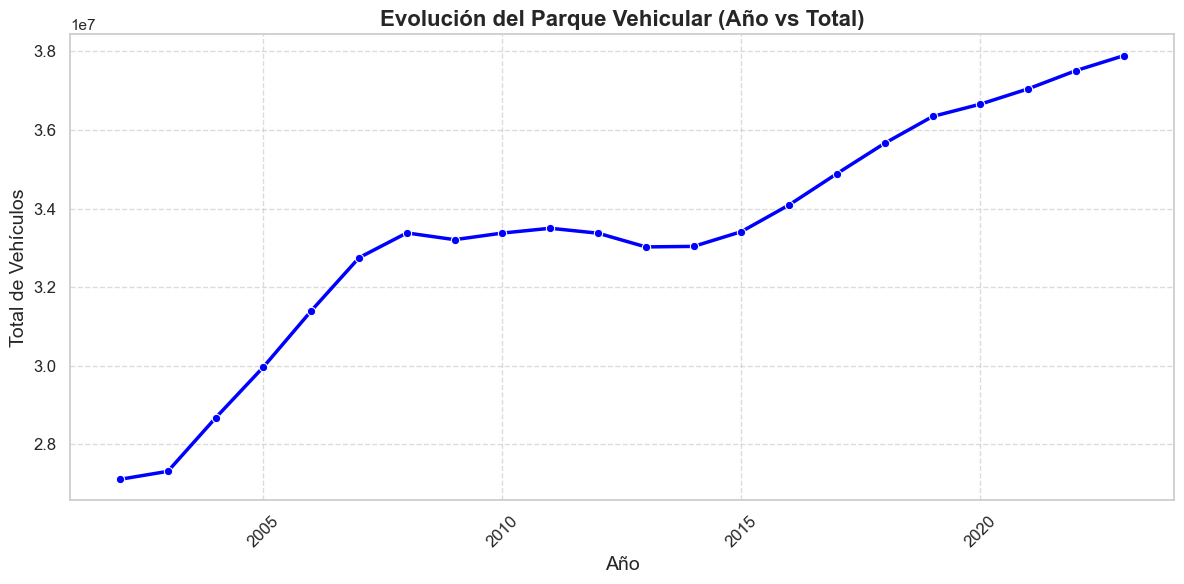

In [ ]:
# Configuración general de estilo
sns.set_theme(style="whitegrid")

# Crear la visualización
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura
sns.lineplot(x='anio', y='total', data=df_parque_vehicular_es, color="blue", marker="o", linewidth=2.5)

# Títulos y etiquetas
plt.title("Evolución del Parque Vehicular (Año vs Total)", fontsize=16, fontweight='bold')
plt.xlabel("Año", fontsize=14)
plt.ylabel("Total de Vehículos", fontsize=14)

# Personalización de ejes
plt.xticks(fontsize=12, rotation=45)  # Girar etiquetas en el eje X si es necesario
plt.yticks(fontsize=12)

# Líneas de cuadrícula ajustadas
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()

Evidentemente, se puede apreciar que el parque vehicular en España venía en aumento con fuerza desde principio de los 2000. Sin embargo, este proceso tuvo ciertos cambios a partir del 2008 y hasta el 2015. Durante éstos años confluyeron diversos factores que tuvieron efectos directos en el parque vehicular, cantidad y antiguedad. 
    1. Debido a la crisis económica del 2008, hubo una caída en la demanda de vehículos nuevos por lo que la compra de muchos se pospuso.
    2. El gobierno implementó el Plan 2000E, incentivando la compra de vehículos nuevos y la retirada de vehículos antiguos. Logrando elevar la entrada de vehículos.
    3. A partir del 2015, más del 75% de las fábricas españolas habían incrementado sus niveles de producción a niveles cercanos a los previos a la crisis.

- Todo esto provocó que algunos vehículos antiguos alargaran su vida útil dentro del parque vehicular. A la vez, debido a las decisiones tomadas por el gobierno para incentivar la compra de nuevos vehículos, muchos de de los vehículos desplazados fueron fueron pasados por el deshuesadero.

## Defunciones España

In [148]:
df_defunciones_es = pd.read_csv("C:\\Users\\DELL\\Downloads\\muertes_transito_espana.csv", sep=';')

In [180]:
df_defunciones_es.columns = ['anio', 'fallecidos']

In [181]:
df_defunciones_es.to_csv('../Datos/datos_plus/defunciones_esp.csv')

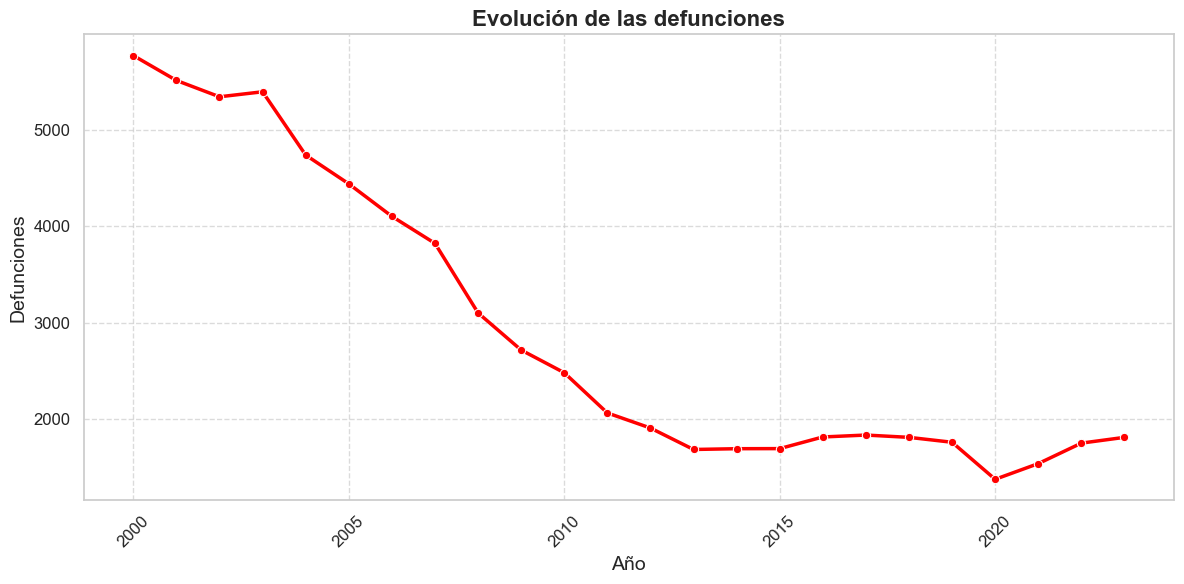

In [ ]:
# Configuración general de estilo
sns.set_theme(style="whitegrid")

# Crear la visualización
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura
sns.lineplot(x='anio', y='fallecidos', data=df_defunciones_es, color="red", marker="o", linewidth=2.5)

# Títulos y etiquetas
plt.title("Evolución de las defunciones", fontsize=16, fontweight='bold')
plt.xlabel("Año", fontsize=14)
plt.ylabel("Defunciones", fontsize=14)

# Personalización de ejes
plt.xticks(fontsize=12, rotation=45)  # Girar etiquetas en el eje X si es necesario
plt.yticks(fontsize=12)

# Líneas de cuadrícula ajustadas
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()

Razones por la disminución:
- Instalación de radares fijos y de tramo para controlar los excesos de velocidad
- Límites de velocidad reducidos en zonas urbanas
- Campañas de uso obligatorio del cinturón de seguridad, evitar el uso del móvil y la concienciación sobre los riesgos del consumo de alcohol y drogas
- Modernización y mantenimiento de carreteras 
- Avances tecnológicos de los vehículos
- Aumento de controles de alcoholemia y drogas
- Implementación del sistema de puntos, desde el 2006. Incentivando comportamientos más seguros
- Multas más severas por infracciones como exceso de velocidad y uso del móvil

## Parque vehicular RD - Antiguedad

In [316]:
df_pvehicular_antiguo_rd = pd.read_excel('C:\\Users\\DELL\\Downloads\\ParqueVehicular2023\\ParqueVehicular2023.xlsx', sheet_name='2.9', skiprows=9, index_col=0)

In [317]:
df_pvehicular_antiguo_rd.head()

,Año de Fabricación,Tipo de Vehículo,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Participación \n%,Unnamed: 12,Unnamed: 13,Unnamed: 14
NaN,NaN,Motocicletas,Automóviles,Jeeps,Carga,Autobuses,Máquinas Pesadas,Volteo,Otros,Total,NaN,NaN,NaN,NaN
NaN,2000a/,1169602,543452,92937,252007,54525,14435,13374,15138,2155470,0.37,NaN,NaN,NaN
NaN,2001,20732,25730,28700,15234,3159,841,743,574,95713,0.02,NaN,NaN,0.89
NaN,2002,28244,21865,29723,15052,5057,803,881,553,102178,0.02,NaN,NaN,NaN
NaN,2003,25871,18397,19079,11691,4125,429,792,418,80802,0.01,NaN,NaN,NaN


In [318]:
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd.iloc[1:, :11]
df_pvehicular_antiguo_rd.columns = ['anio', 'motocicletas', 'automóviles', 'jeeps', 'carga', 'autobuses', 'máquinas_pesadas', 'volteo', 'otros', 'total', 'participacion %']

In [319]:
df_pvehicular_antiguo_rd.reset_index(drop=True, inplace=True)
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['motocicletas'].notnull()]
df_pvehicular_antiguo_rd['participacion %'] = df_pvehicular_antiguo_rd['participacion %'] * 100

In [320]:
df_pvehicular_antiguo_rd['anio'] = df_pvehicular_antiguo_rd['anio'].apply(lambda x: x.replace('a/', '') if 'a/' in str(x) else x)

In [321]:
df_pvehicular_antiguo_rd.sort_values(by='participacion %', ascending=False)[1:6]

,anio,motocicletas,automóviles,jeeps,carga,autobuses,máquinas_pesadas,volteo,otros,total,participacion %
0,2000,1169602,543452,92937,252007,54525,14435,13374,15138,2155470,37.09
15,2015,137948,47087,36744,11163,5980,490,182,365,239959,4.13
16,2016,124465,48158,44587,13258,5882,592,195,341,237478,4.09
17,2017,118017,37229,44357,11688,5334,760,366,317,218068,3.75
14,2014,109288,53738,36209,8872,5545,386,163,244,214445,3.69


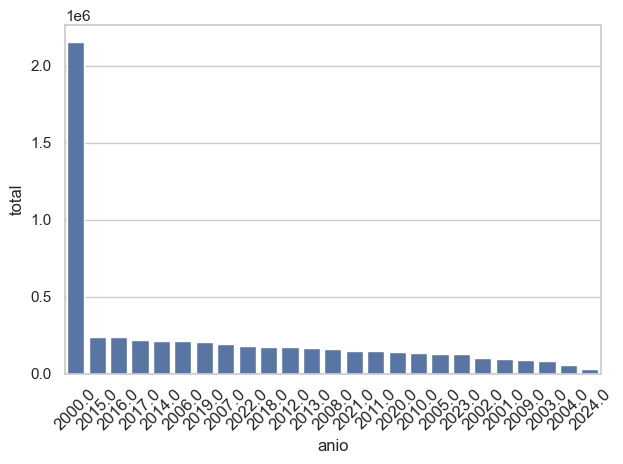

In [ ]:
df_pvehicular_antiguo_rd_ordenado = df_pvehicular_antiguo_rd.sort_values(by='participacion %', ascending=False)
df_pvehicular_antiguo_rd_ordenado['anio'] = df_pvehicular_antiguo_rd_ordenado['anio'].astype(str)
sns.barplot(x='anio', y='total', data=df_pvehicular_antiguo_rd_ordenado)
plt.xticks(fontsize=12, rotation=45)
plt.tight_layout()

Vemos como la mayor cantidad de coches está concentrada en vehículos de más de 25 años.

In [322]:
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd[:-1]

In [323]:
df_pvehicular_antiguo_rd_copia = df_pvehicular_antiguo_rd.copy()

In [324]:
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd.iloc[:,:-1]

In [325]:
df_pvehicular_antiguo_rd.to_csv('../Datos/datos_plus/antiguedad_pvehicular.csv')

In [326]:
sencillo = df_pvehicular_antiguo_rd_copia[['anio', 'total', 'participacion %']]

In [327]:
s_col = df_pvehicular_antiguo_rd.columns.tolist()
df_pvehicular_antiguo_rd[s_col] = df_pvehicular_antiguo_rd[s_col].astype(float)

In [331]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2000, 2005)]['participacion %'].sum()

45.10591152333344

Más del 45 de los vehículos de la República Dominicana a la fecha del 2023, poseen más de 20 años.

In [332]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2006, 2010)]['participacion %'].sum()

13.556843635602682

In [333]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2011, 2015)]['participacion %'].sum()

16.232699718184207

In [334]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2016, 2020)]['participacion %'].sum()

16.791134160562034

In [335]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2020, 2024)]['participacion %'].sum()

10.737825268702478

## Vehículos por género de su propietario por propietario privado - jurídico

In [250]:
df_pveh_genero_pais = pd.read_excel('C:\\Users\\DELL\\Downloads\\ParqueVehicular2023\\ParqueVehicular2023.xlsx', sheet_name='2.5', skiprows=34, index_col=0)

In [251]:
df_pveh_genero_pais = df_pveh_genero_pais.dropna(how='all')

In [252]:
df_pveh_genero_pais = df_pveh_genero_pais.iloc[:,1:]

In [253]:
df_pveh_genero_pais.reset_index(drop=True, inplace=True)

In [254]:
df_pveh_genero_pais['Tipo'] = df_pveh_genero_pais['Tipo'].str.replace(r'\d+/.*', '', regex=True).str.strip()

In [255]:
df_pveh_genero_pais.columns = ['tipo', 'femenino', 'masculino', 'persona_juridica', 'total']

In [256]:
columnas_int = df_pveh_genero_pais.columns.tolist()[1:5]

In [257]:
df_pveh_genero_pais[columnas_int] = df_pveh_genero_pais[columnas_int].astype(int)

In [258]:
df_pveh_genero_pais = df_pveh_genero_pais.T[1:]
df_pveh_genero_pais.reset_index(inplace=True)
df_pveh_genero_pais.columns = ['propietario','motocicletas', 'automoviles', 'jeep', 'carga', 'autobuses', 'maquinas_pesadas', 'volteo', 'otros', 'total']
df_pveh_genero_pais = df_pveh_genero_pais[:-1]

In [259]:
df_pveh_genero_pais

,propietario,motocicletas,automoviles,jeep,carga,autobuses,maquinas_pesadas,volteo,otros,total
0,femenino,409307,302093,226092,40883,18414,1236,1746,959,1000734
1,masculino,1831819,693906,392251,297969,75255,10588,12703,7764,3322258
2,persona_juridica,1039891,126335,60125,182425,37021,15757,11095,15244,1487894


In [350]:
total_sumado = df_pveh_genero_pais['total'].sum()

df_pveh_genero_pais['porcentaje'] = (df_pveh_genero_pais['total'] / total_sumado) * 100

df_pveh_genero_pais


,propietario,motocicletas,automoviles,jeep,carga,autobuses,maquinas_pesadas,volteo,otros,total,porcentaje
0,femenino,409307,302093,226092,40883,18414,1236,1746,959,1000734,17.22
1,masculino,1831819,693906,392251,297969,75255,10588,12703,7764,3322258,57.17
2,persona_juridica,1039891,126335,60125,182425,37021,15757,11095,15244,1487894,25.61


Anotaciones:
    - A resaltar, más del 50% de los vehículos registrados para el 2023 corresponden a hombres. Una cuarta parte, corresponde a personas jurídicas (25.61%) mientras que menos del 20% (17.22%) corresponde a mujeres. 
Esto puede tener sentido considerando que la gran masa de conductores que salen a la calle a trabajar resulta que son hombres, tanto aquellos que utilizan sus medios solo para transporte como aquellos que usan su vehículo como modo de trabajo personal (taxistas, repartidores, etc). Sin embargo, esto puede dejar de lado algunos casos donde los hombres otorgan vehículos a mujeres para ser conducidos por ellas pero se mantienen bajo el registro del hombre.

In [260]:
df_pveh_genero_pais.to_csv('../Datos/datos_plus/parquev_privado_publico.csv')

## Vehículos por género de su propietario por provincia

In [167]:
df_pveh_genero_rd_prov = pd.read_excel('C:\\Users\\DELL\\Downloads\\ParqueVehicular2023\\ParqueVehicular2023.xlsx', sheet_name='2.6', skiprows=7, index_col=0)

In [168]:
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov[['Provincia', 'Género', 'Unnamed: 4', 'Total', 'Género.1', 'Unnamed: 11', 'Total.1']]

In [169]:
df_pveh_genero_rd_prov.columns = ['provincia', 'femenino', 'masculino', 'total', '%_fem', '%_masc', 'total_%']
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov.iloc[1:]
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov[df_pveh_genero_rd_prov['femenino'].notnull()]

In [170]:
df_pveh_genero_rd_prov.reset_index(drop=True, inplace=True)

In [185]:
df_pveh_genero_rd_prov['total'] = df_pveh_genero_rd_prov['total'].astype(int)

In [192]:
df_pveh_genero_rd_prov_copia = df_pveh_genero_rd_prov.copy()
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov[['provincia', 'femenino', 'masculino', 'total']]

In [193]:
df_pveh_genero_rd_prov.to_csv('../Datos/datos_plus/parquev_genero_prov.csv')

In [348]:
df_pveh_genero_rd_prov_copia

,provincia,femenino,masculino,total,%_fem,%_masc,total_%
0,Azua,11977,54694,66671,0.18,0.82,1.00
1,Bahoruco,3191,12020,15211,0.21,0.79,1.00
2,Barahona,10933,41140,52073,0.21,0.79,1.00
3,Dajabón,6001,16761,22762,0.26,0.74,1.00
4,Distrito Nacional,242930,891466,1134396,0.21,0.79,1.00
5,Duarte,32178,101469,133647,0.24,0.76,1.00
6,El Seibo,6974,18786,25760,0.27,0.73,1.00
7,Elías Piña,1467,5913,7380,0.20,0.80,1.00
8,Espaillat,24792,90549,115341,0.21,0.79,1.00
9,Hato Mayor,7728,19513,27241,0.28,0.72,1.00


In [362]:
df_pveh_genero_rd_prov_copia['%_masc'] * 100

0    82.00
1    79.00
2    79.00
3    73.60
4    78.60
5    75.90
6    72.90
7    80.10
8    78.50
9    71.60
10   78.90
11   76.30
12   72.20
13   76.20
14   73.00
15   75.00
16   73.60
17   75.30
18   74.20
19   77.30
20   72.60
21   77.60
22   73.20
23   81.70
24   81.10
25   76.80
26   73.20
27   74.40
28   77.90
29   78.20
30   75.90
31   79.50
32   76.90
Name: %_masc, dtype: object

In [365]:
min_valor_masc = df_pveh_genero_rd_prov_copia['%_masc'].min()
fila_masc = df_pveh_genero_rd_prov_copia[df_pveh_genero_rd_prov_copia['%_masc'] == min_valor_masc]
fila_masc

,provincia,femenino,masculino,total,%_fem,%_masc,total_%
9,Hato Mayor,7728,19513,27241,0.28,0.72,1.00


In [366]:
min_valor_fem = df_pveh_genero_rd_prov_copia['%_fem'].min()
fila_fem = df_pveh_genero_rd_prov_copia[df_pveh_genero_rd_prov_copia['%_fem'] == min_valor_fem]
fila_fem

,provincia,femenino,masculino,total,%_fem,%_masc,total_%
0,Azua,11977,54694,66671,0.18,0.82,1.00


En todas las provincias, los hombres tienen más del 70% de los vehículos. Resaltando como mínimo la provincia de Hato Mayor con un 72% de los vehículos perteneciente al sexo masculino. En el caso contrario, la provincia con menor presencia de posesión de vehículos de parte del género femenino es Azua, donde no supera el 20% de los vehículos.

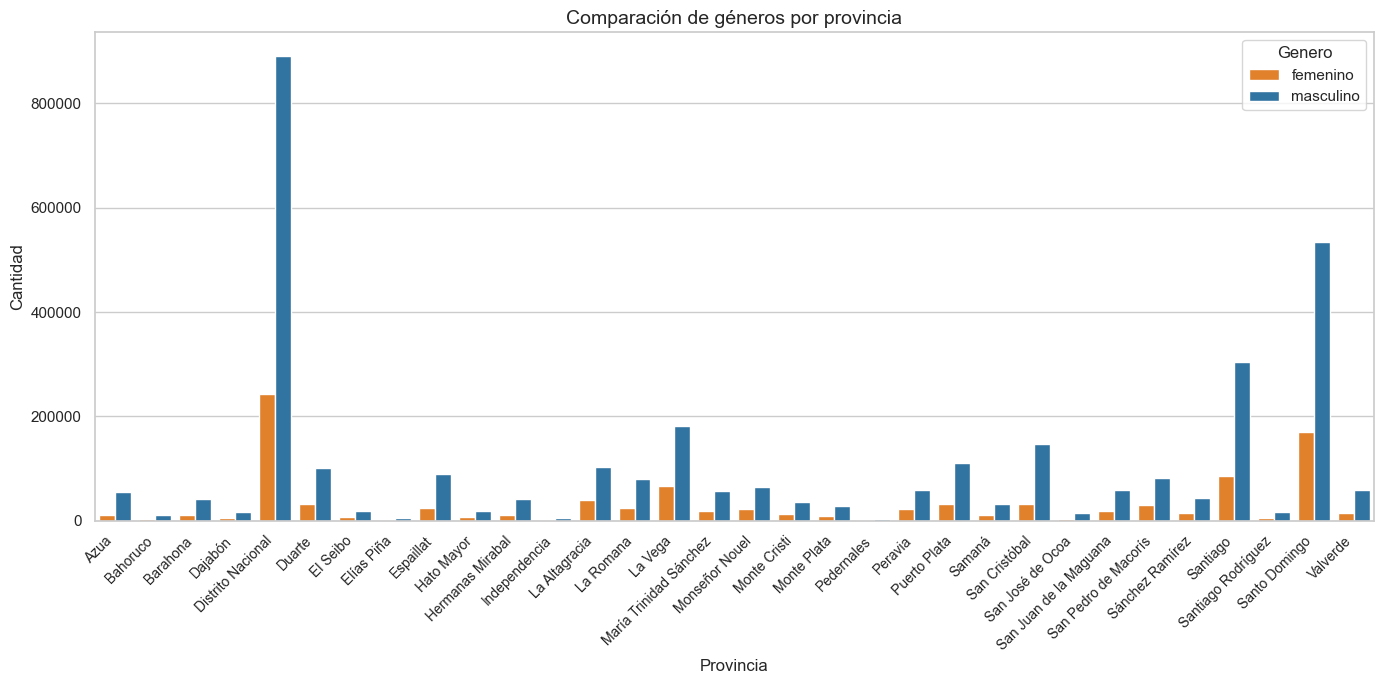

In [359]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 7))

# Crear un gráfico de barras agrupadas
df_long = df_pveh_genero_rd_prov_copia.iloc[:-1][['provincia', 'femenino', 'masculino']].melt(id_vars='provincia', var_name='Genero', value_name='Cantidad')
sns.barplot(x='provincia', y='Cantidad', hue='Genero', data=df_long, palette={'femenino': '#ff7f0e', 'masculino': '#1f77b4'})

# Ajustar el eje X para que las etiquetas sean legibles
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Cantidad', fontsize=12)
plt.xlabel('Provincia', fontsize=12)
plt.title('Comparación de géneros por provincia', fontsize=14)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()


## Infracciones de tránsito

In [437]:
df_infracciones_1 = pd.read_excel("C:\\Users\\DELL\\Downloads\\Infracciones de Tránsito, DIGESETT, 2010 - 2017.xlsx")
df_infracciones_2 = pd.read_excel("C:\\Users\\DELL\\Downloads\\Infracciones de Tránsito, DIGESETT, 2018 - 2024.xlsx")

In [438]:
df_infracciones_1.columns = ['infracciones', 'total', 'anio']
df_infracciones_2.columns = df_infracciones_2.columns.str.lower()
df_infracciones_2.rename(columns={'año':'anio'}, inplace=True)

In [439]:
df_infracciones_2['total'] = df_infracciones_2.iloc[:,1:13].sum(axis=1)

In [440]:
df_infracciones_2.reset_index(drop=True, inplace=True)

In [441]:
df_infracciones_2.columns = df_infracciones_2.columns.str.strip()

In [442]:
# Crear una nueva columna de porcentaje, filtrando por cada año
df_infracciones_2.groupby('anio')['total'].sum()

anio
2018     812930
2019    1003852
2020     614808
2021    1522201
2022    2026132
2023    1503418
2024    1948238
Name: total, dtype: int64

In [443]:
# Calcular el porcentaje dentro de cada año usando transform
df_infracciones_2['porcentaje'] = df_infracciones_2.groupby('anio')['total'].transform(lambda x: (x / x.sum()) * 100)

# Verificar los resultados
df_infracciones_2[['anio', 'infracciones', 'total', 'porcentaje']]


,anio,infracciones,total,porcentaje
0,2018,Transitar sin tablilla (art. 42),527,0.06
1,2018,Exceso de pasajeros (art. 67),4153,0.51
2,2018,Niños en el asiento delantero (art. 69),2601,0.32
3,2018,Pasajeros en vehículos de carga (art. 124),11393,1.40
4,2018,Violar señales de tránsito (art. 132),12044,1.48
...,...,...,...,...
642,2024,35.- Transitar sin Luces (Art.- 170),74975,3.85
643,2024,36.- Transitar con Luces LED (Resol. 009-18 IN...,4132,0.21
644,2024,37.- Transitar con Gomas Lisas (Resol. 002-19 ...,8995,0.46
645,2024,43-A.- Aditamentos en las Placas,2936,0.15


In [461]:
df_infracciones_2[df_infracciones_2['anio'] == 2020].sort_values(by='porcentaje', ascending=False).head(15)

,infracciones,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre,anio,total,porcentaje
225,No Uso del Casco Protector (Art.- 251),24335,17268,7696,328,3783,4938,5068,6883,18643,31335,29868,27997,2020,178142,28.98
157,Respeto a las señales del Semáforo (LUZ ROJA) ...,8213,5498,2831,25,1181,3741,2729,4378,6129,7061,8366,9920,2020,60072,9.77
197,Transitar sin Seguro o Vencido (Art.- 217),8981,5292,2189,116,792,1806,1760,2628,3864,6166,6205,6102,2020,45901,7.47
196,Transitar sin Licencia o Vencida (Art.- 210),8671,5336,2745,146,729,1689,1542,1825,2174,3131,3712,4122,2020,35822,5.83
208,No Uso del Cinturón de Seguridad (Art.- 231 No...,4625,3197,1784,28,454,1134,1111,1961,2485,4473,5341,4962,2020,31555,5.13
233,Exceso de Velocidad (Art.- 264),4068,2970,1627,112,1217,1674,1594,2122,2888,3310,3242,3634,2020,28458,4.63
215,Estacionarse en Lugar Prohibido (Art.- 237),2920,1766,1174,48,686,1788,1374,2375,2857,3252,3502,3662,2020,25404,4.13
174,Falta o Pérdida de Medidas de Seguridad (Art.-...,2951,1825,1014,1068,1742,1858,1125,1479,1846,2433,2639,2552,2020,22532,3.66
227,Transitar en Vía Contraria (Art.- 251),2100,1628,973,71,614,1239,1478,2396,2665,3230,2868,2639,2020,21901,3.56
169,Obstruir el Tránsito (Art.-146),2528,1710,950,37,530,1273,1009,1533,2121,2635,2439,2513,2020,19278,3.14


In [446]:
# Calcular el porcentaje dentro de cada año usando transform
df_infracciones_1['porcentaje'] = df_infracciones_1.groupby('anio')['total'].transform(lambda x: (x / x.sum()) * 100)

# Verificar los resultados
df_infracciones_1[df_infracciones_1['anio'] == 2011]


,infracciones,total,anio,porcentaje
11,VIOLAR LA LUZ ROJA,43938,2011,14.27
12,TRANSITAR SIN CASCO,20561,2011,6.68
13,TRANSITAR SIN CINTURON,42142,2011,13.69
14,HABLAR POR CELULAR,32657,2011,10.61
15,VIA CONTRARIA,37645,2011,12.23
16,LICENCIA VENCIDA,15765,2011,5.12
17,CONDUCIR SIN LICENCIA,31779,2011,10.32
18,TRANSITAR EN VIA CONTRARIA,15456,2011,5.02
19,OBSTRUIR EL TRANSITO,15768,2011,5.12
20,ESTACIONARSE EN LUGARES PROHIBIDO,21372,2011,6.94


In [451]:
df_infracciones_1_org = df_infracciones_1[df_infracciones_1['anio'] == 2012].sort_values(by='porcentaje', ascending=False)

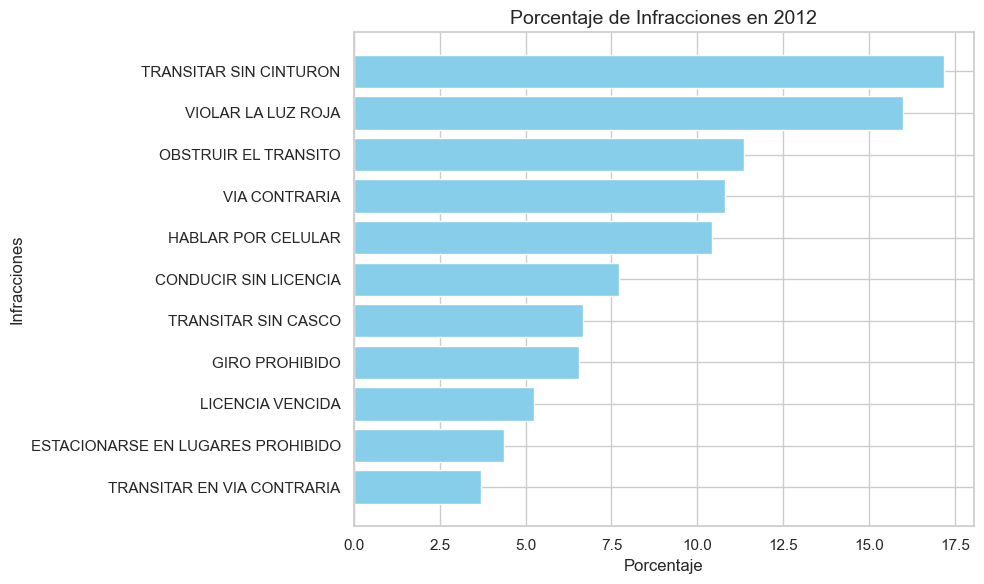

In [455]:
import matplotlib.pyplot as plt

# Filtrar por el rango de años entre 2010 y 2017
df_infracciones_filtrado = df_infracciones_1[
    (df_infracciones_1['anio'] >= 2010) & (df_infracciones_1['anio'] <= 2017)
]

# Filtrar por un año específico, por ejemplo, 2012, y ordenar por porcentaje
df_infracciones_2012 = df_infracciones_filtrado[
    df_infracciones_filtrado['anio'] == 2012
].sort_values(by='porcentaje', ascending=False)

# Crear la visualización para 2012
plt.figure(figsize=(10, 6))
plt.barh(df_infracciones_2012['infracciones'], df_infracciones_2012['porcentaje'], color='skyblue')
plt.xlabel('Porcentaje', fontsize=12)
plt.ylabel('Infracciones', fontsize=12)
plt.title('Porcentaje de Infracciones en 2012', fontsize=14)
plt.gca().invert_yaxis()  # Invertir el eje Y para que la barra más grande esté arriba
plt.tight_layout()
plt.show()


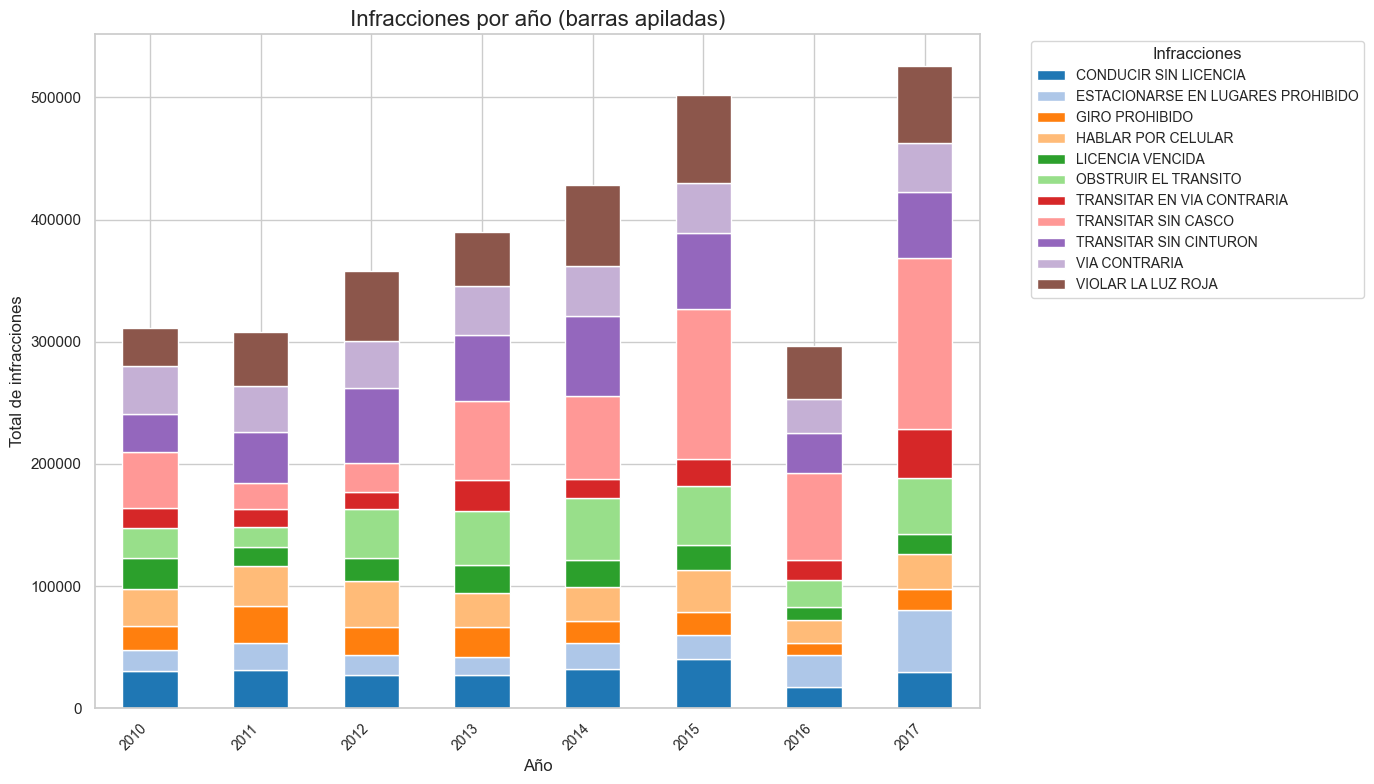

In [458]:
import matplotlib.pyplot as plt

# Pivotar el DataFrame para que los años sean el índice y las infracciones sean las columnas
df_pivot = df_infracciones_1.pivot_table(
    index='anio', 
    columns='infracciones', 
    values='total', 
    aggfunc='sum'
)

# Crear el gráfico de barras apiladas
df_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=plt.cm.tab20.colors  # Colores para las infracciones
)

# Personalizar el gráfico
plt.title('Infracciones por año (barras apiladas)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Total de infracciones', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Infracciones', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# Mostrar el gráfico
plt.show()
